# LFP Analysis Pipeline 
Christine Liu

## Imports, Global Variable Definition

In [651]:
%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import numpy as np  
import tdt
from tdt import read_block, read_sev, epoc_filter, download_demo_data
import elephant
from neo.core import Block, Segment, ChannelIndex, AnalogSignal
import quantities as pq
from quantities import mV, kHz
import math
import pandas as pd
import pathlib
from scipy import signal
from scipy import sparse 
from scipy import linalg
from scipy.sparse.linalg import spsolve 
from scipy import sparse
from scipy.sparse import linalg
from numpy.linalg import norm
from scipy.signal import find_peaks
from numpy import *
from matplotlib import *
from scipy.stats import sem
from copy import deepcopy as dcopy
import os
#from pathlib import Path
import glob
import shutil
import fnmatch

In [652]:
# DEFINE exp_group AS 'needs_mapping' OR 'mapped'. RECORDINGS TAKEN BEFORE 21/5/28 NEED MAPPING
exp_group = 'needs_mapping'

#electrode coordinates
coords = [[0], [0.1], [0.2], [0.3], [0.4], [0.5], [0.6], [0.7],[0.8],[0.9],[1.0],[1.1],[1.2],[1.3],[1.4],[1.5]]

# WE ADD AN OFFSET BECAUSE THERES A DELAY FROM WHEN WE EXECUTED THE ELECTRICAL STIM AND WHEN IT ACTUALLY OCCURED. YOU HAVE TO PLAY AROUND WITH THIS VALUE FOR EACH RECORDING
delay_offset = 0.002

# THIS DURATION IS FOR HOW MUCH OF THE RECORDING AFTER THE OFFSET WE WANT TO LOOK AT
duration = 0.06

presynaptic_duration = 0.005

#adjust region for CSD measurement to avoid artifact
#adjusted_csd_start = 0
#adjusted_csd_end = 0.05

# plt.plot(postsynapticsource6a, label = "220406A")
# plt.plot(postsynapticsource6b, label = "220406B")
# plt.plot(postsynapticsource6d, label = "220406D")
# plt.plot(postsynapticsource8a, label = "220408A")
# plt.plot(postsynapticsource8c, label = "220408C")





## Loading Data
Functionized, takes in your block path, and returns a dictionary in which to access various features
        
        'data': data,
        'channel_data': channel_data,
        'channel_data_SU':channel_data_SU,
        'time1': time1,
        'time2': time2, 
        'time_Raw1': time_Raw1, 
        'time_SU_2': time_SU_2

In [653]:
def getData(BLOCK_PATH): 
    
    print(BLOCK_PATH)
    
    data = read_block(BLOCK_PATH, evtype=['epocs', 'streams'])
    all_data = data
    pulse_num = 3  #0-5
    print('Types of stream data in this Struct:\n', data.streams, '\n')
    print('Types of epoc data in this Struct:\n', data.epocs, '\n')


    # CREATES YOUR X-AXIS (TIME) FROM SINGLE/MULTI UNIT DATA (time_SU_1) OR RAW LFP DATA (time_Raw1)
    time_SU_2 = np.linspace(1, len(data.streams.SU_1.data[0]), len(data.streams.SU_1.data[0])) / data.streams.SU_1.fs
    time_Raw1 = np.linspace(1, len(data.streams.Raw1.data[0]), len(data.streams.Raw1.data[0])) / data.streams.Raw1.fs

    # THIS CREATES THE TIME POINTS BETWEEN WHICH WE WANT TO LOOK
    time1 = data.epocs.PC1_.onset[pulse_num]+delay_offset
    print(time1)
    time2 = data.epocs.PC1_.onset[pulse_num]+delay_offset+duration
    print(time2)

    if exp_group=='needs_mapping':
#         newmapper = [7,5,3,1,6,4,2,0,14,12,10,8,15,13,11,9]
#         mapper = reverse(newmapper)
        mapper = [15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]
        mapped_data = data.streams.Raw1.data[mapper,:]
        mapped_data_SU = data.streams.SU_1.data[mapper,:]
        channel_data = mapped_data
        channel_data_SU = mapped_data_SU
    else:
        channel_data = data.streams.Raw1.data
        channel_data_SU = data.streams.SU_1.data
        
    
    #new_time = plot_the_lfps(folder_name,data)
    
    data_dictionary =  {
        'data': data,
        'channel_data': channel_data,
        'channel_data_SU':channel_data_SU,
        'time1': time1,
        'time2': time2, 
        'time_Raw1': time_Raw1, 
        'time_SU_2': time_SU_2
    }       
    
    
    return  data_dictionary,all_data

## LFP Visualization

In [654]:
def plot_the_lfps(folder_name,all_data):       
    
    data = all_data
    
    time_Raw1 = np.linspace(1, len(data.streams.Raw1.data[0]), len(data.streams.Raw1.data[0])) / data.streams.Raw1.fs
    
    
    #Create LFP matrix
    time1 = data.epocs.PC1_.onset[0]
    time2 = data.epocs.PC1_.onset[0]+duration    
    
    t1=int(time1* data.streams.Raw1.fs)
    t = int(time2* data.streams.Raw1.fs)    
      
    LFP_matrix = []
    size = data.streams.Raw1.data[:,t1:t].shape[1]
    LFP_matrix = np.zeros((4,size,16)) 
    
    

    
    fig, axs = plt.subplots(nrows=16, ncols=1, figsize=(5, 40), sharex=True)
    
    plot_list = [0,1,2,3,4]
    
    for a in range(16):
        
        LFP_matrix = []
    
        for p in plot_list:
            
            time1 = data.epocs.PC1_.onset[p]
            time2 = data.epocs.PC1_.onset[p]+duration

            t1=int(time1* data.streams.Raw1.fs)
            t = int(time2* data.streams.Raw1.fs) # int rounds it to the nearest integer
            
            corrected_time =  [x - time_Raw1[t1] for x in time_Raw1[t1:t]] 

            
            axs[a].plot(corrected_time,data.streams.Raw1.data[a,t1:t]*1e6, color='cornflowerblue')

            axs[a].set_ylabel(str(a+1), fontsize = 12)
            axs[a].set_ylim(-3000, 3000)
            axs[a].set_xlim(0, 0.04)
            
           
            matrix_data = data.streams.Raw1.data[a,t1:t]
            matrix_data_cropped =  matrix_data[:1460]

            LFP_matrix.append(np.transpose(matrix_data_cropped))
            #LFP_matrix.append(np.transpose(data.streams.Raw1.data[a,t1:t]))
            
        cropped_time = corrected_time[:1460]
        LFP_mean = np.mean(LFP_matrix, axis=0)
        LFP_mean_transposed = np.transpose(LFP_mean)
        axs[a].plot(cropped_time,LFP_mean_transposed*1e6, color='red')
        axs[a].axvline(x= delay_offset, color='b', ls=':',lw=1)
        axs[a].axvline(x= delay_offset+presynaptic_duration, color='b', ls=':',lw=1)
        
        
        
        


    condition = folder_name
    
    axs[15].set_xlabel('time (s)', fontsize = 12)
    
    axs[0].set_title(condition)
    fig.text(-0.2, 0.5, 'Amplitude ($\mu$V)', ha='center', va='center', rotation='vertical')
    
    condition = folder_name
    
    fig.suptitle(condition)
    
    
   

    #save_name_svg = f'{output_folder_path}{slice_id}_{condition}_lfp.svg'
    save_name_png = f'{output_folder_path}{slice_id}_{condition}_lfp.png'
    
    #plt.savefig(save_name_svg,,dpi = 600)
    plt.savefig(save_name_png,dpi = 600)
    
    plt.show()
    
    new_time = cropped_time
    
    return new_time




In [655]:
#Function to put the CSD data into a matrix from the LFP file
def createCSD(data, lfpdata): 
    lfp_transposed2 = np.transpose(lfpdata)
    sig = AnalogSignal(lfp_transposed2,units='V',sampling_rate=data['data'].streams.Raw1.fs/12 *pq.Hz)
    chx = ChannelIndex(name='Probe 0', index=range(16),
                        channel_ids=range(16),
                        channel_names=['Channel %i' % chid
                                        for chid in range(16)],
                        coordinates=coords)
    chx.analogsignals.append(sig)
    sig.channel_index=chx
    csd_return = elephant.current_source_density.estimate_csd(sig, method='KCSD1D', process_estimate=True)
    csd_cut = np.transpose(csd_return)
    csd_matrix = csd_cut
    
    t_max = np.max(np.abs(csd_matrix))
    levels = np.linspace(-1 * t_max, t_max, 32)
    cmap=cm.seismic

    return csd_matrix, t_max, levels, cmap
             

In [656]:
#Function to get average 

def avgLFP(data): 
    
    time_Raw1 = np.linspace(1, len(data['data'].streams.Raw1.data[0]), len(data['data'].streams.Raw1.data[0])) / data['data'].streams.Raw1.fs

  
    time1 = data['data'].epocs.PC1_.onset[0]+delay_offset
    time2 = data['data'].epocs.PC1_.onset[0]+delay_offset+duration
    t1=int(time1* data['data'].streams.Raw1.fs)
    t = int(time2* data['data'].streams.Raw1.fs)
    


    LFP_matrix = []
    size = data['channel_data'][:,t1:t].shape[1]
    LFP_matrix = np.zeros((4,size,16))
    for a in range(4):
        b = a 
        time1 = data['data'].epocs.PC1_.onset[b]+delay_offset
        time2 = data['data'].epocs.PC1_.onset[b]+delay_offset+duration
        t1=int(time1* data['data'].streams.Raw1.fs)
        t = int(time2* data['data'].streams.Raw1.fs) # int rounds it to the nearest integer
        corrected_time =  [x - time_Raw1[t1] for x in time_Raw1[t1:t]] 
        lfp_transposed = np.transpose(data['channel_data'][:,t1:t])
        LFP_matrix[a,0:size] = lfp_transposed
    #take average
    
    
    LFP_mean = LFP_matrix.mean(axis=0)
    LFP_mean_transposed = np.transpose(LFP_mean) 
    
     
    plt.plot(corrected_time,LFP_mean)    
    plt.show()
    
    
    
    return LFP_mean, LFP_mean_transposed,corrected_time





In [673]:
def avg_sweep(data,folder_name,scaling_set,new_time):
    
    condition = folder_name
    LFP_mean, LFP_mean_transposed,corrected_time = avgLFP(data)
    
#     plt.plot(LFP_mean)
#     plt.ylabel('some numbers')
#     plt.show()
    
    #print(LFP_mean)
    
    fig = plt.figure(figsize = (10,10))
    
    #Add the plot 2D CSD plot
    ax = fig.add_subplot(projection='3d')      

    decim_data = signal.decimate(LFP_mean_transposed,12,ftype='fir')
    #decim_data = LFP_mean_transposed
    
    
    print(f'decim shape: {np.shape(decim_data)}')
    
    #decim_data = np.flipud(decim_data)

    # #just putting together empty matrix for CSD data      
    csd_matrix = []
    csd_matrix = np.zeros((100,decim_data.shape[1]))
    
    new_size = decim_data.shape[1]
    csd_matrix, t_max, levels, cmap = createCSD(data, decim_data) #put CSD data into matrix 
    print(np.shape(csd_matrix))
    csd_data_points_number = len(csd_matrix[1])
    print(f'num csd points: {csd_data_points_number}')   
    
    
    time1 = data['data'].epocs.PC1_.onset[0]+delay_offset
    time2 = data['data'].epocs.PC1_.onset[0]+delay_offset+duration
    t1=int(time1* data['data'].streams.Raw1.fs)
    t = int(time2* data['data'].streams.Raw1.fs) # int rounds it to     
    
    
    total_duration = duration-delay_offset
    
    adjusted_t = np.linspace(0,  total_duration, csd_data_points_number)   
    
    change_scaling_max = 160
    
    levels = np.linspace(-1 * t_max, t_max, 160)


    X,Y = np.meshgrid(adjusted_t,list(reversed(range(100))))
    surf = ax.plot_surface(X,Y, csd_matrix,cmap =cm.viridis,vmin=-1 * change_scaling_max,vmax=change_scaling_max)
    im = ax.contourf(X, Y,csd_matrix,  offset=change_scaling_max*-1, levels=levels, extend='neither', cmap=cm.viridis, vmin = -1*change_scaling_max,vmax=change_scaling_max)
    
    ax2 = fig.add_subplot(projection='3d',sharex=ax)

    shift_plot_position = 7

    for b in range(16):
        if b<=shift_plot_position:
            channel_data = ((decim_data[b]*1e6)/4)+(shift_plot_position-b)*46.875
            channel_data = ((decim_data[b]*1e6)/4)+(shift_plot_position-b)*46.875
        
    
        else:
            channel_data = ((decim_data[b]*1e6)/4)-(b-shift_plot_position)*46.875
            channel_data = ((decim_data[b]*1e6)/4)+(shift_plot_position-b)*46.875
            
    
        Z = np.full((csd_data_points_number),np.min(csd_matrix)) #102
        #Z = np.full((csd_data_points_number),1000) 
        chan=ax2.plot3D(adjusted_t,channel_data,Z, color='k',clip_on=False,linewidth=0.5)
         
        
    

    

    scalebar = 150*4
    print("150um is {}uV".format(scalebar))

    tick_labels = [0,300,600,900,1200,1500]
    tick_labels.reverse()
    
    ax.set_xlabel('time(s)')
    ax.set_ylabel('Y(um)')
    ax.set_ylim([6,99])
    ax.yaxis.set_ticklabels(tick_labels)
    #ax.set_zlim([change_scaling_max*-1,change_scaling_max])
    ax.set_zlim([change_scaling_max*-1,change_scaling_max])
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.w_zaxis.line.set_lw(0.)
    ax.get_zaxis().set_ticks([])
    ax.set_xlim(-0,0.050)

    #ax2 parameters
    #ax2.set_ylim(-150,150)
    ax2.set_ylim(-385,385)
    ax2.yaxis.set_ticklabels([-375,-225,-75,75,225,375])
    #ax2.set_zlim([-10000,4000])
    ax2.set_zlim([np.min(csd_matrix),np.max(csd_matrix)])
    #ax2.axvline(x= delay_offset+presynaptic_duration, color='b', ls=':',lw=1)

    ax2.patch.set_alpha(0.0)
    ax2.grid(False)
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.xaxis.pane.set_edgecolor('w')
    ax2.yaxis.pane.set_edgecolor('w')
    ax2.zaxis.pane.set_edgecolor('w')
    ax2.xaxis.pane.set_alpha(0)
    ax2.yaxis.pane.set_alpha(0)
    ax2.zaxis.pane.set_alpha(0)
    ax2.get_yaxis().set_ticks([])
    ax2.w_zaxis.line.set_lw(0.)
    ax2.get_zaxis().set_ticks([])
    ax2.set_xlim(0,0.050)
    
    def on_move(event):
        if event.inaxes == ax:
            ax2.view_init(elev=ax.elev, azim=ax.azim)
        elif event.inaxes == ax2:
            ax.view_init(elev=ax2.elev, azim=ax2.azim)
        else:
            return
        fig.canvas.draw_idle()

    c1 = fig.canvas.mpl_connect('motion_notify_event', on_move)

    # place shared colorbar to the right
    ticks = np.linspace(-1 * change_scaling_max, change_scaling_max, 3, endpoint=True)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax, ticks = ticks)

    #fig.colorbar(im, cax=cbar_ax,boundaries=np.linspace(-1 * change_scaling_max, change_scaling_max, 1),ticks = ticks)

    #c = fig.colorbar()
    #fig.clim(-100, 100) 


    #plt.xlim(0,0.03)
    ax.view_init(elev=15, azim=300)
    ax2.view_init(elev=15, azim=300)
   

    fig.suptitle(condition)
   

    save_name_svg = f'{output_folder_path}{slice_id}_{condition}_plot.svg'
    save_name_png = f'{output_folder_path}{slice_id}_{condition}_plot.png'
    # plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(save_name_svg)
    plt.savefig(save_name_png)
    
    csd_dict = {"csd_matrix_for_calc": csd_matrix, "X_vals": X, "Y_vals": Y}    
    
    return csd_dict
    
    #change_scaling_max





In [674]:
def  quantify_csd(csd_dict,folder_name): 
    #print(csd_dict)
    
    csd_matrix = csd_dict["csd_matrix_for_calc"]  
    X = csd_dict["X_vals"]    
    Y = csd_dict["Y_vals"]  
    
        
    
    csd_sinks_only = [[0 if csd_matrix[x][a]>0 else csd_matrix[x][a] for a in range(len(csd_matrix[x]))] 
                      for x in range(len(csd_matrix))]
    csd_sinks_only = np.array(csd_sinks_only[:][:])   
    
    csd_sink_vol = ((np.abs(csd_sinks_only).sum())/1000)
    
    #Presynaptic period = 0 - 10 ms
    #Post_synaptic period = 50 - end
    #index_end_pre_period = np.where(Y>0.005)[0][0]
    #print(csd_matrix)
    
    print(f'index of greater than presynaptic cutoff {index_end_pre_period} recalculate threshold {Y[index_end_pre_period]}')
    
    #print(Y)
    
#     plt.plot(X)    
#     plt.show()
    #Total_length_recording
    
        
    #only_presynaptic_sink
    #presynaptic range
    
    #only_postsynaptic_sink
    
    
    
    
    
    csd_sources_only = [[0 if csd_matrix[x][a]<0 else csd_matrix[x][a] for a in range(len(csd_matrix[x]))] 
                      for x in range(len(csd_matrix))]
    csd_sources_only = np.array(csd_sources_only[:][:])
    
    
    
    
    
    # CA3 sink location correction

    fig = plt.figure(figsize = (10,10))
#     t_max = np.max(np.abs(csd_sinks_only))
#     levels = np.linspace(-1 * t_max, t_max, 100)

    ax = fig.add_subplot(projection='3d')
#     adjusted_t = np.linspace(0, 0.05, 102)
    #X,Y = np.meshgrid(adjusted_t2[nudge_points_start:(nudge_points_end*-1)],list(reversed(range(100))))
    surf = ax.plot_surface(X,Y, csd_sinks_only,cmap =cm.viridis)
    #im = ax.contourf(X, Y,csd_sinks_only,  offset=np.min(csd_cropped), levels=levels, extend='both', cmap=cm.viridis, vmin = -1*t_max,vmax=t_max)


    #plt.show()   
    
    
    csd_sink_vol = ((np.abs(csd_sinks_only).sum())/1000) # this is the volume
    csd_source_vol = ((np.abs(csd_sources_only).sum())/1000) # this is the volume
    csd_total_vol = csd_sink_vol + csd_source_vol
    csd_min = (np.min(csd_sinks_only)) # this is the minimum
    
   
    csd_cond_table.append(folder_name)
    csd_total_vol_table.append(csd_total_vol) 
    csd_min_table.append(csd_min) 
    csd_source_vol_table.append(csd_source_vol)
    csd_sink_vol_table.append(csd_sink_vol)
    
    
    
    
    
    
   

In [675]:
def two_dimen_csd(data,folder_name):
    i=0
    for i in range(1):   
        LFP_mean, LFP_mean_transposed,corrected_time = avgLFP(data)
        decim_data = signal.decimate(LFP_mean_transposed,12,ftype='fir')

        # #just putting together empty matrix for CSD data      
        csd_matrix = []
        csd_matrix = np.zeros((100,decim_data.shape[1]))
        new_size = decim_data.shape[1]
        csd_matrix, t_max, levels, cmap = createCSD(data, decim_data) #put CSD data into matrix 

        #create figure for CSD and LFPs
        fig,ax = plt.subplots(figsize=(10, 10))
        time1 = data['data'].epocs.PC1_.onset[0]+delay_offset
        time2 = data['data'].epocs.PC1_.onset[0]+delay_offset+duration

        t1=int(time1* data['data'].streams.Raw1.fs/12)
        t = int(time2* data['data'].streams.Raw1.fs/12) # int rounds it to the nearest integer
        if data['time_Raw1'][t1:t].shape[0]>new_size:
            t=t-1
        elif data['time_Raw1'][t1:t].shape[0]<new_size:
            t=t+1 

        print(t1, t, new_size, LFP_mean_transposed.shape, csd_matrix.shape, data['time_Raw1'].shape)
        im = ax.contourf(data['time_Raw1'][t1:t], list(reversed(range(100))), csd_matrix[:,:], levels=levels, cmap=cmap)
    #     ax.clim(-100, 100)
        im.set_clim(vmin=-160, vmax=160)
        ax.set_xlabel('time(s)')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.set_ylim([0,100])
        ax.spines['left'].set_visible(True)
        ax.set_ylabel('Y(um)')
        ax.yaxis.set_ticklabels([0,300,600,900,1200,1500])

        # Now, attempt placement of the peak x marks
        bodge =7.8
        for b in range(16):
            ax2= ax.twinx()
            if b<=bodge:
                channel_data = ((decim_data[b,0:new_size]*1e6)/15)+(bodge-b)*46.875
    #             channel_data = ((decim_data[b,0:new_size]*1e6)/15)+(8-b)*30.875
            else:
                channel_data = ((decim_data[b,0:new_size]*1e6)/15)-(b-bodge)*46.875
    #             channel_data = ((decim_data[b,0:new_size]*1e6)/15)+(8-b)*30.875
            ax2.plot(data['time_Raw1'][t1:t], channel_data, color='k', linewidth = 0.5, clip_on=False)  
            ax2.set_ylim(-375,375)
            #ax2.yaxis.set_visible(False)
            ax2.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            ax2.spines['left'].set_visible(False)
            
        condition = folder_name

         #place shared colorbar to the right
        t_max = 160
        ticks = np.linspace(-1 * t_max, t_max, 4, endpoint=True)
        fig.colorbar(im, orientation='vertical', format='%.2f',ticks=ticks)
    #     fig.clim(-90, 90) 
        fig.suptitle(condition)
        
        save_name_svg = f'{output_folder_path}{slice_id}_{condition}_plot_2D.svg'
        save_name_png = f'{output_folder_path}{slice_id}_{condition}_plot_2D.png'      
        plt.savefig(save_name_svg)
        plt.savefig(save_name_png)



In [676]:
def  quantify_csd(csd_dict,folder_name): 
    #print(csd_dict)
    
    csd_matrix = csd_dict["csd_matrix_for_calc"]  
    X = csd_dict["X_vals"]    
    Y = csd_dict["Y_vals"]  
    
    print(type(X))
    
    
    #print("************************************************************")
#     print(csd_matrix)
#     plt.plot(X,Y, 'o-r')
#     plt.ylabel('some numbers')
#     plt.show()
    time_list = (X[0,:])
    presyn_index= np.where(time_list>0.010)[0][0]
    
    #print(presyn_index)   
        
    
    csd_sinks_only = [[0 if csd_matrix[x][a]>0 else csd_matrix[x][a] for a in range(len(csd_matrix[x]))] 
                      for x in range(len(csd_matrix))]
    csd_sinks_only = np.array(csd_sinks_only[:][:])
    csd_presynaptic_sink = np.array(csd_sinks_only[:][:presyn_index])    
    csd_postsynaptic_sink = np.array(csd_sinks_only[:][presyn_index+1:])
    
    
    csd_sink_vol = ((np.abs(csd_sinks_only).sum())/1000) # this is the volume
    csd_sink_presynaptic_vol = ((np.abs(csd_presynaptic_sink).sum())/1000) # this is the volume
    csd_sink_postsynaptic_vol = ((np.abs(csd_postsynaptic_sink).sum())/1000) # this is the volume
    
    print(f'total sink {csd_sink_vol} presynaptic {csd_sink_presynaptic_vol} postsynaptic {csd_sink_postsynaptic_vol}')
    
    
    csd_sources_only = [[0 if csd_matrix[x][a]<0 else csd_matrix[x][a] for a in range(len(csd_matrix[x]))] 
                      for x in range(len(csd_matrix))]
    csd_sources_only = np.array(csd_sources_only[:][:])
    csd_presynaptic_source = np.array(csd_sources_only[:][:presyn_index])    
    csd_postsynaptic_source = np.array(csd_sources_only[:][presyn_index+1:])
    
    
    csd_source_vol = ((np.abs(csd_sources_only).sum())/1000) # this is the volume
    csd_source_presynaptic_vol = ((np.abs(csd_presynaptic_source).sum())/1000) # this is the volume
    csd_source_postsynaptic_vol = ((np.abs(csd_postsynaptic_source).sum())/1000) # this is the volume
    
    
    print(f'total source {csd_source_vol} presynaptic {csd_source_presynaptic_vol} postsynaptic {csd_source_postsynaptic_vol}')
    
    
    

    fig = plt.figure(figsize = (10,10))


    ax = fig.add_subplot(projection='3d')
#     adjusted_t = np.linspace(0, 0.05, 102)
    #X,Y = np.meshgrid(adjusted_t2[nudge_points_start:(nudge_points_end*-1)],list(reversed(range(100))))
    surf = ax.plot_surface(X,Y, csd_sinks_only,cmap =cm.viridis)
    #im = ax.contourf(X, Y,csd_sinks_only,  offset=np.min(csd_cropped), levels=levels, extend='both', cmap=cm.viridis, vmin = -1*t_max,vmax=t_max)


    plt.show()   
    
    
    
    csd_source_vol = ((np.abs(csd_sources_only).sum())/1000) # this is the volume
    csd_total_vol = csd_sink_vol + csd_source_vol
    csd_min = (np.min(csd_sinks_only))  #this is the minimum
    
   
    csd_cond_table.append(folder_name)
    csd_total_vol_table.append(csd_total_vol) 
    csd_min_table.append(csd_min) 
    csd_source_vol_table.append(csd_source_vol)
    csd_sink_vol_table.append(csd_sink_vol)    
    
    
    csd_sink_presynaptic_vol = ((np.abs(csd_presynaptic_sink).sum())/1000) # this is the volume
    csd_sink_postsynaptic_vol = ((np.abs(csd_postsynaptic_sink).sum())/1000) # this is the volume
    
    csd_source_presynaptic_vol = ((np.abs(csd_presynaptic_source).sum())/1000) # this is the volume
    csd_source_postsynaptic_vol = ((np.abs(csd_postsynaptic_source).sum())/1000) # this is the volume
    
    csd_source_presynaptic_vol_table.append(csd_source_presynaptic_vol)
    csd_source_postsynaptic_vol_table.append(csd_source_postsynaptic_vol)
    
    csd_sink_presynaptic_vol_table.append(csd_sink_presynaptic_vol)
    csd_sink_postsynaptic_vol_table.append(csd_sink_postsynaptic_vol)
    
    csd_total_presynaptic_vol_table.append(csd_source_presynaptic_vol+csd_sink_presynaptic_vol)
    csd_total_postsynaptic_vol_table.append(csd_source_postsynaptic_vol+csd_sink_postsynaptic_vol)   
    
    
    
    

Caged_STX
Subject1-F1_acsf
C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/control_data/Subject1-F1_acsf/
read from t=0s to t=102.94s
Types of stream data in this Struct:
 SU_1	[struct]
Raw1	[struct] 

Types of epoc data in this Struct:
 PC1_	[struct]
Pe1_	[struct]
Pe2_	[struct] 

31.27450944
31.334509439999998


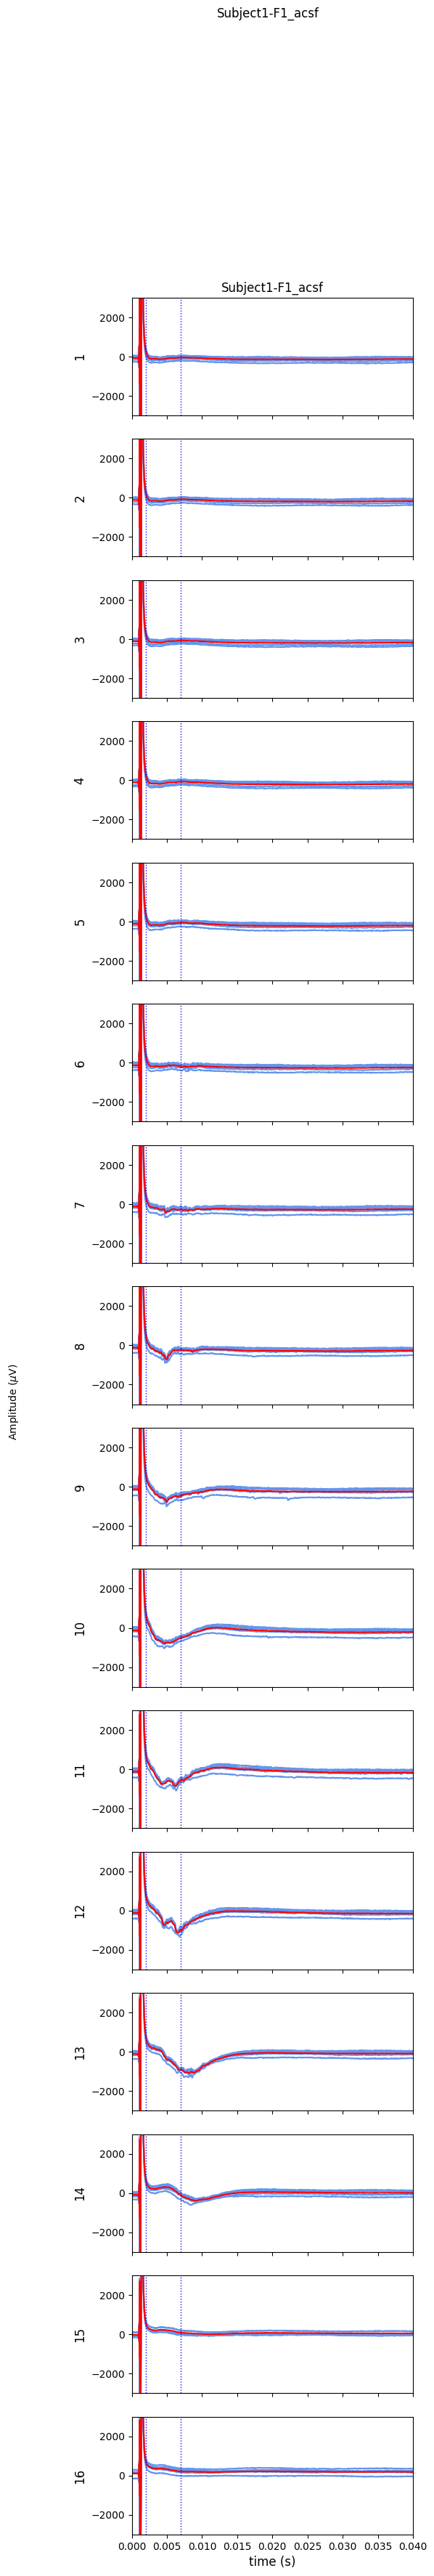

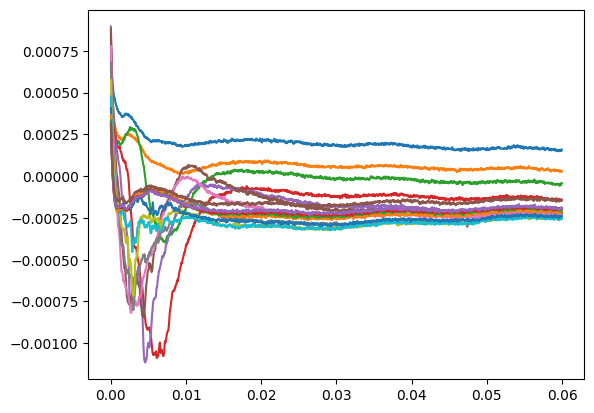

decim shape: (16, 123)
No lambda given, using defaults
Cross validating R (all lambda) : 0.23


C:\Users\dw2471\Anaconda3\envs\synapse_analysis\lib\site-packages\elephant\current_source_density_src\KCSD.py:397: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.estm_x = np.mgrid[self.xmin:self.xmax:np.complex(0,nx)]
C:\Users\dw2471\Anaconda3\envs\synapse_analysis\lib\site-packages\elephant\current_source_density_src\utility_functions.py:74: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guid

R, lambda : 0.23 1.333521432163324e-05
(100, 123)
num csd points: 123
150um is 600uV


C:\Users\dw2471\AppData\Local\Temp\ipykernel_3728\1745612915.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(tick_labels)
C:\Users\dw2471\AppData\Local\Temp\ipykernel_3728\1745612915.py:98: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_lw(0.)


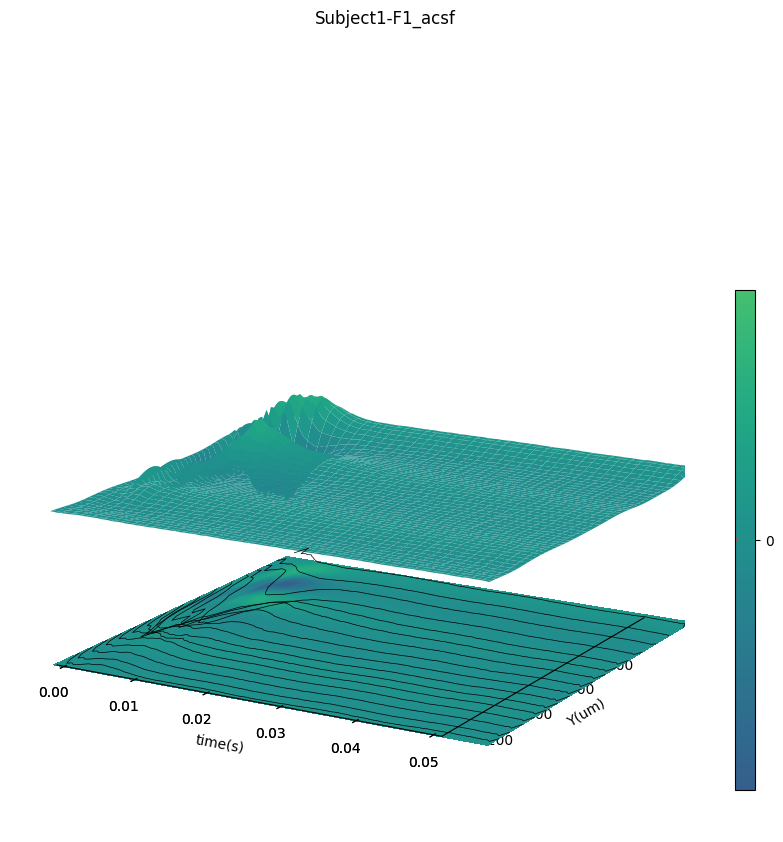

No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 1.333521432163324e-05
2592 2715 123 (16, 1465) (100, 123) (2512896,)
<class 'numpy.ndarray'>
total sink 27.149567530295464 presynaptic 9.073349927181704 postsynaptic 16.960096643635275
total source 20.0770042102117 presynaptic 11.309143695706206 postsynaptic 8.716567930360732


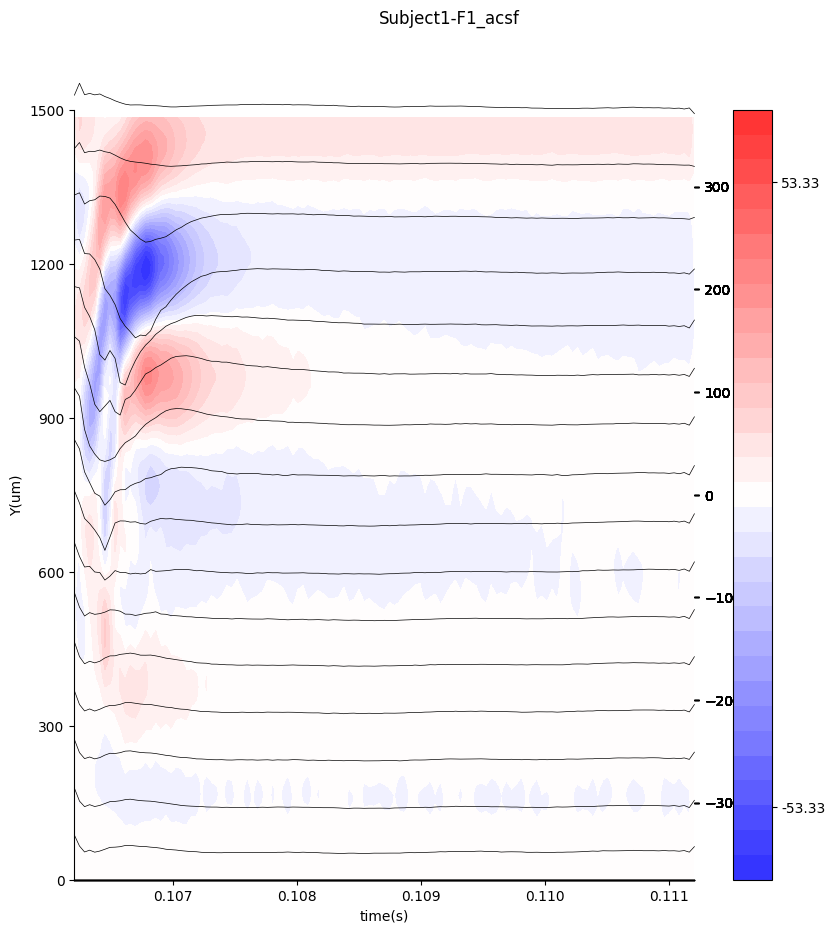

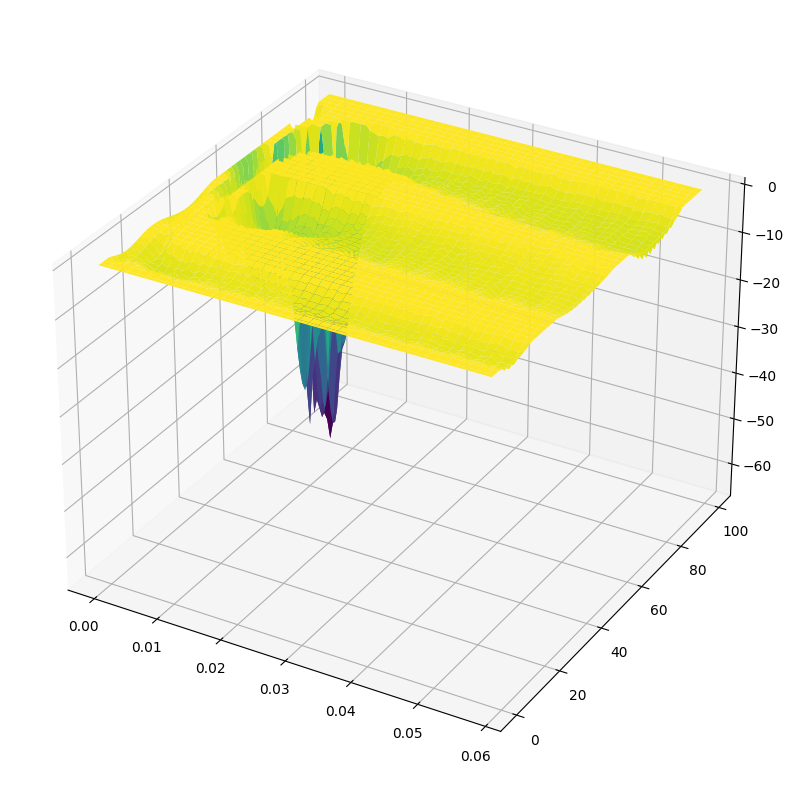

Subject1-F2_kna
C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/control_data/Subject1-F2_kna/
read from t=0s to t=102.94s
Types of stream data in this Struct:
 SU_1	[struct]
Raw1	[struct] 

Types of epoc data in this Struct:
 PC1_	[struct]
Pe1_	[struct]
Pe2_	[struct] 

31.58781248
31.64781248


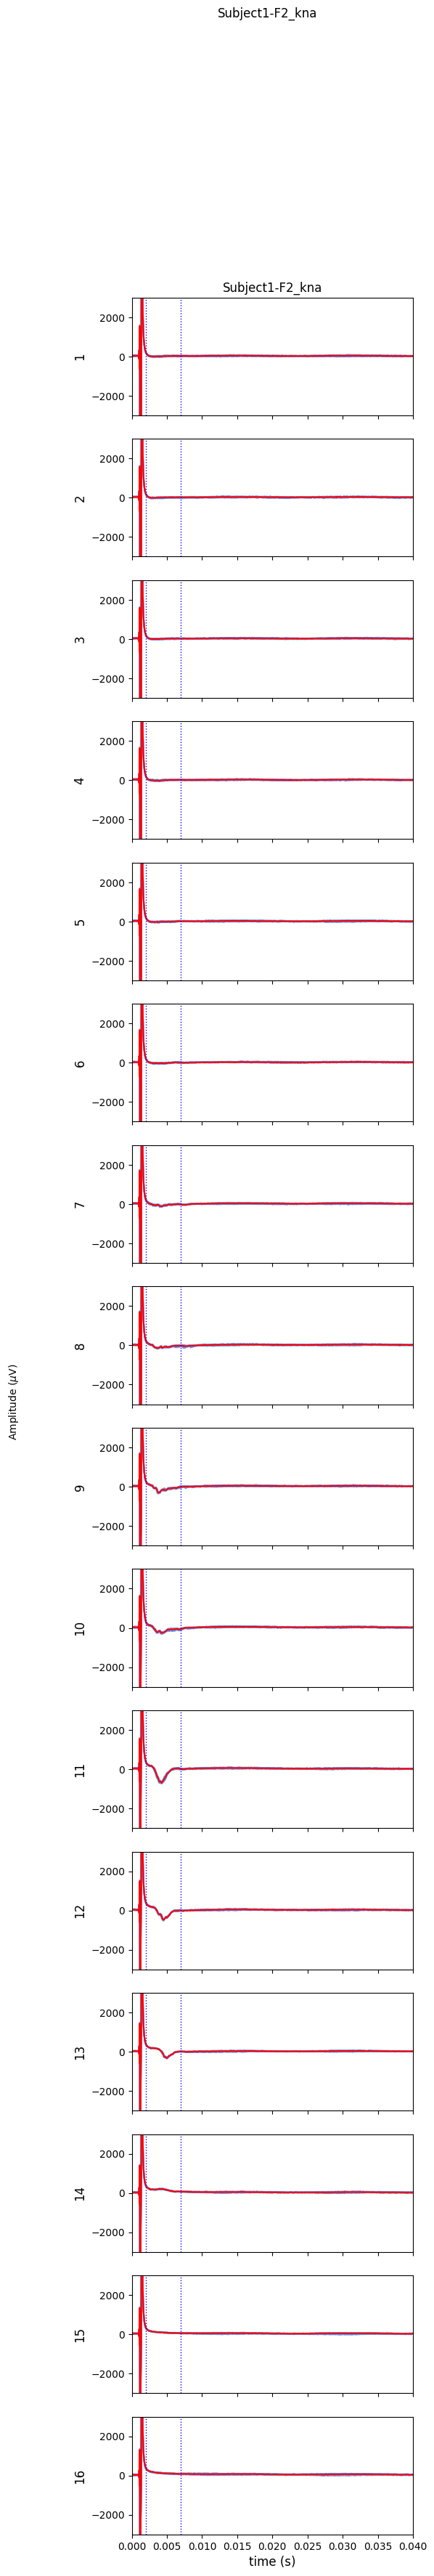

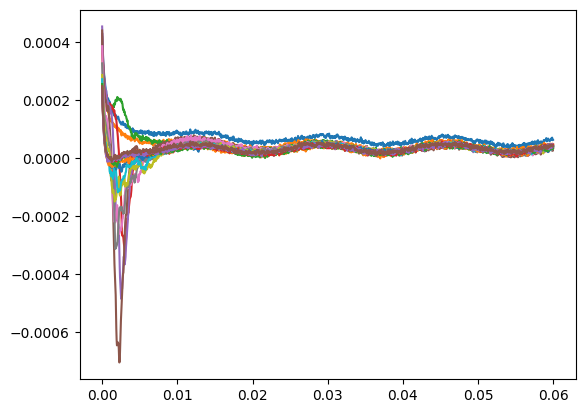

decim shape: (16, 123)
No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 0.00012115276586285876
(100, 123)
num csd points: 123
150um is 600uV


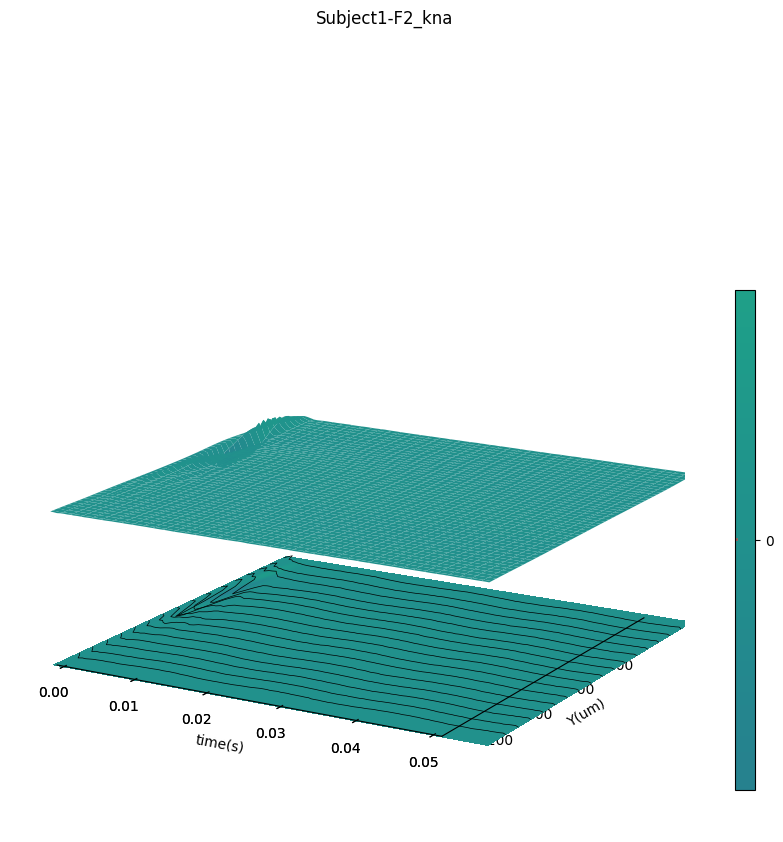

No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 0.00012115276586285876
3230 3353 123 (16, 1465) (100, 123) (2512896,)
<class 'numpy.ndarray'>
total sink 2.520921236384773 presynaptic 0.6136666577063599 postsynaptic 1.8194929453162072
total source 3.0530033076505525 presynaptic 1.624364152954957 postsynaptic 1.4115649828440169


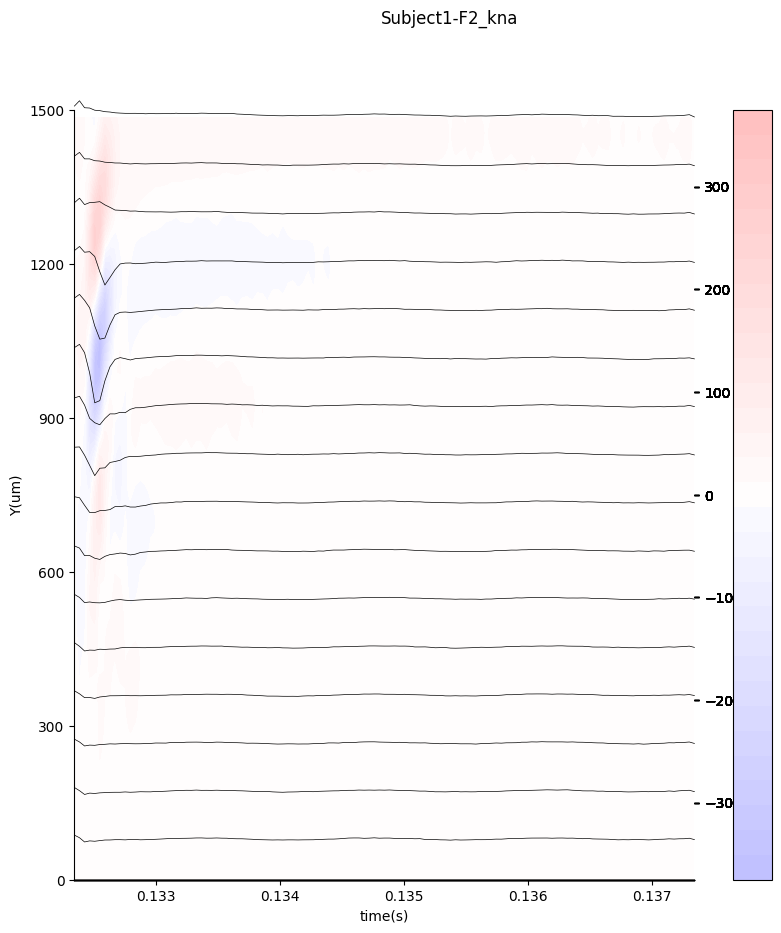

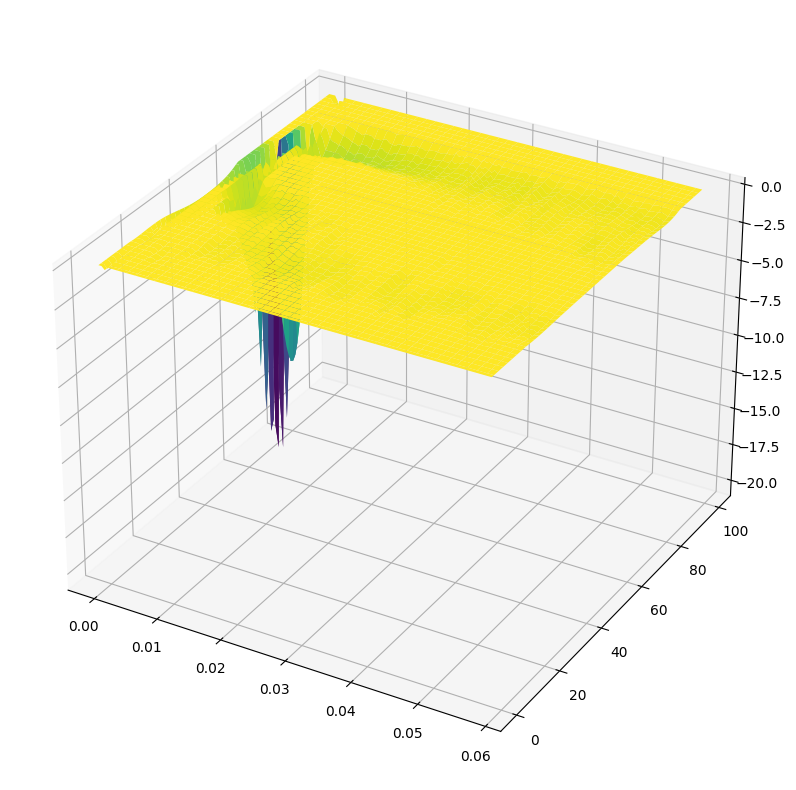

Subject1-F3_ttx
C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/control_data/Subject1-F3_ttx/
read from t=0s to t=102.44s
Types of stream data in this Struct:
 SU_1	[struct]
Raw1	[struct] 

Types of epoc data in this Struct:
 PC1_	[struct]
Pe1_	[struct]
Pe2_	[struct] 

31.282128
31.342128


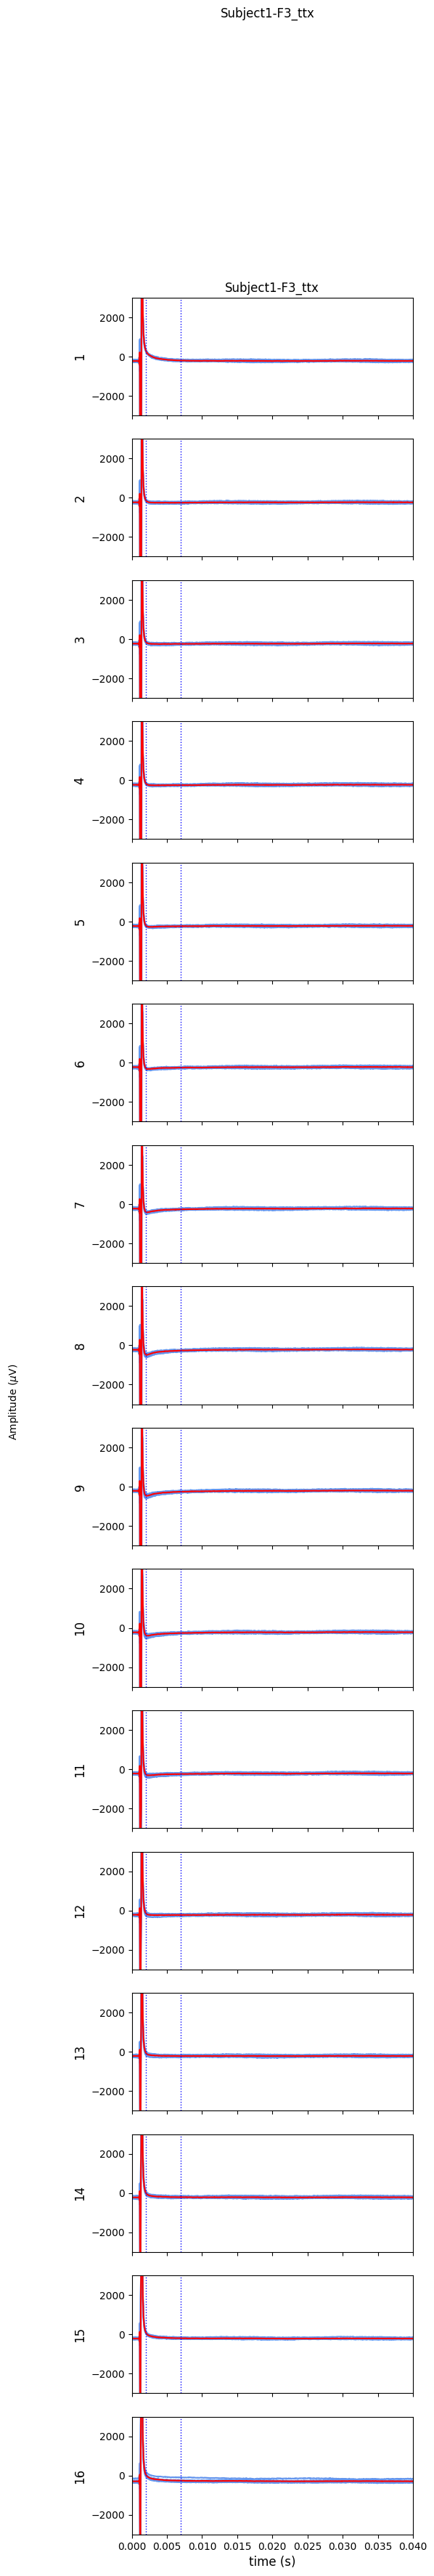

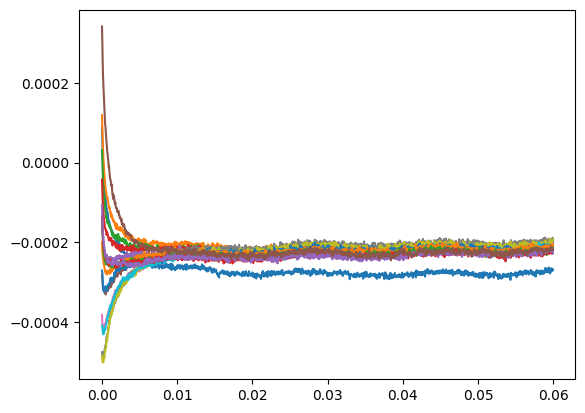

decim shape: (16, 123)
No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 0.00012115276586285876
(100, 123)
num csd points: 123
150um is 600uV


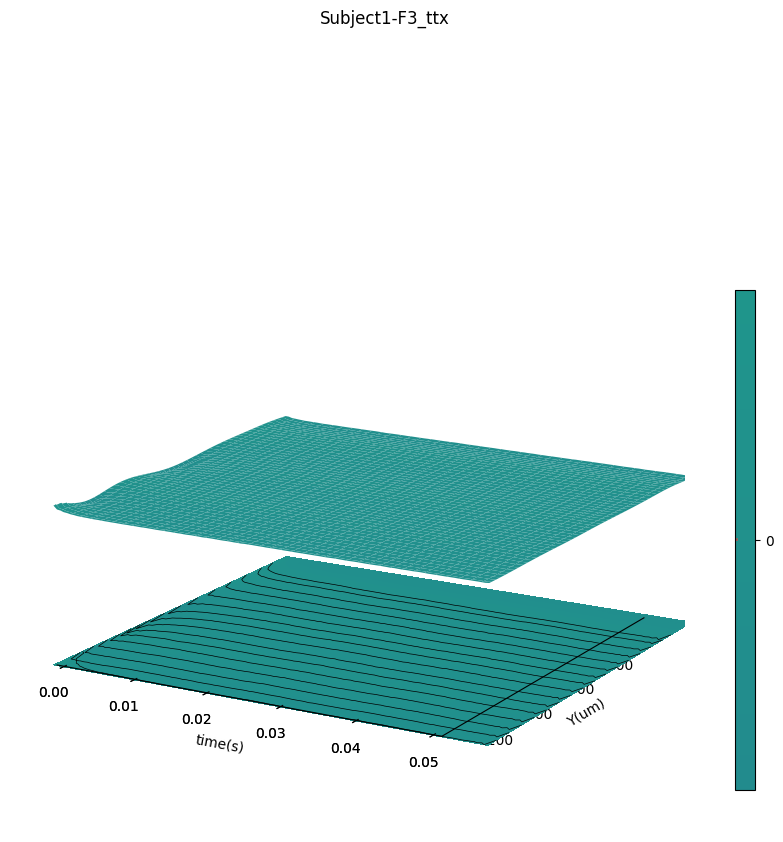

No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 0.00012115276586285876
2608 2731 123 (16, 1465) (100, 123) (2500608,)
<class 'numpy.ndarray'>
total sink 6.470402386142395 presynaptic 2.1353154240886885 postsynaptic 4.3350869620537065
total source 1.6956655892654258 presynaptic 1.113640651640952 postsynaptic 0.521992408031937


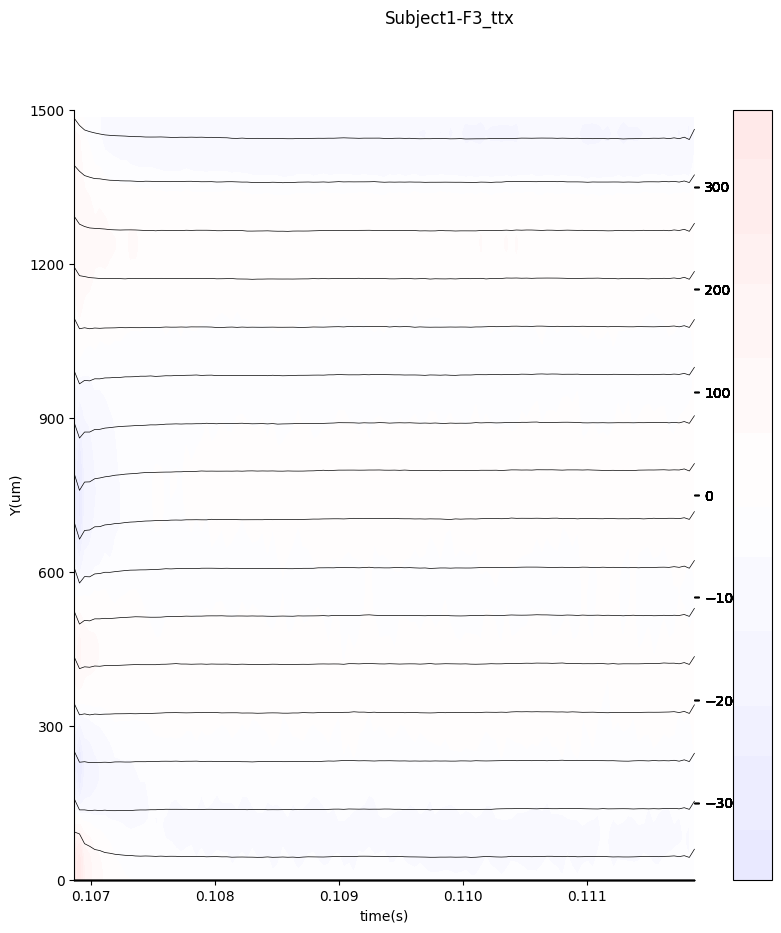

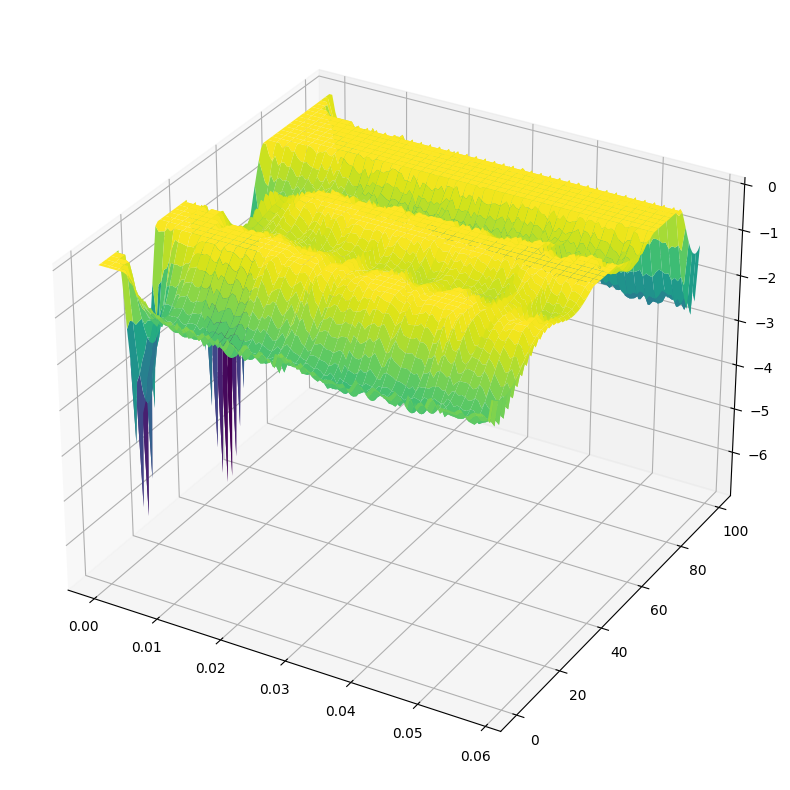

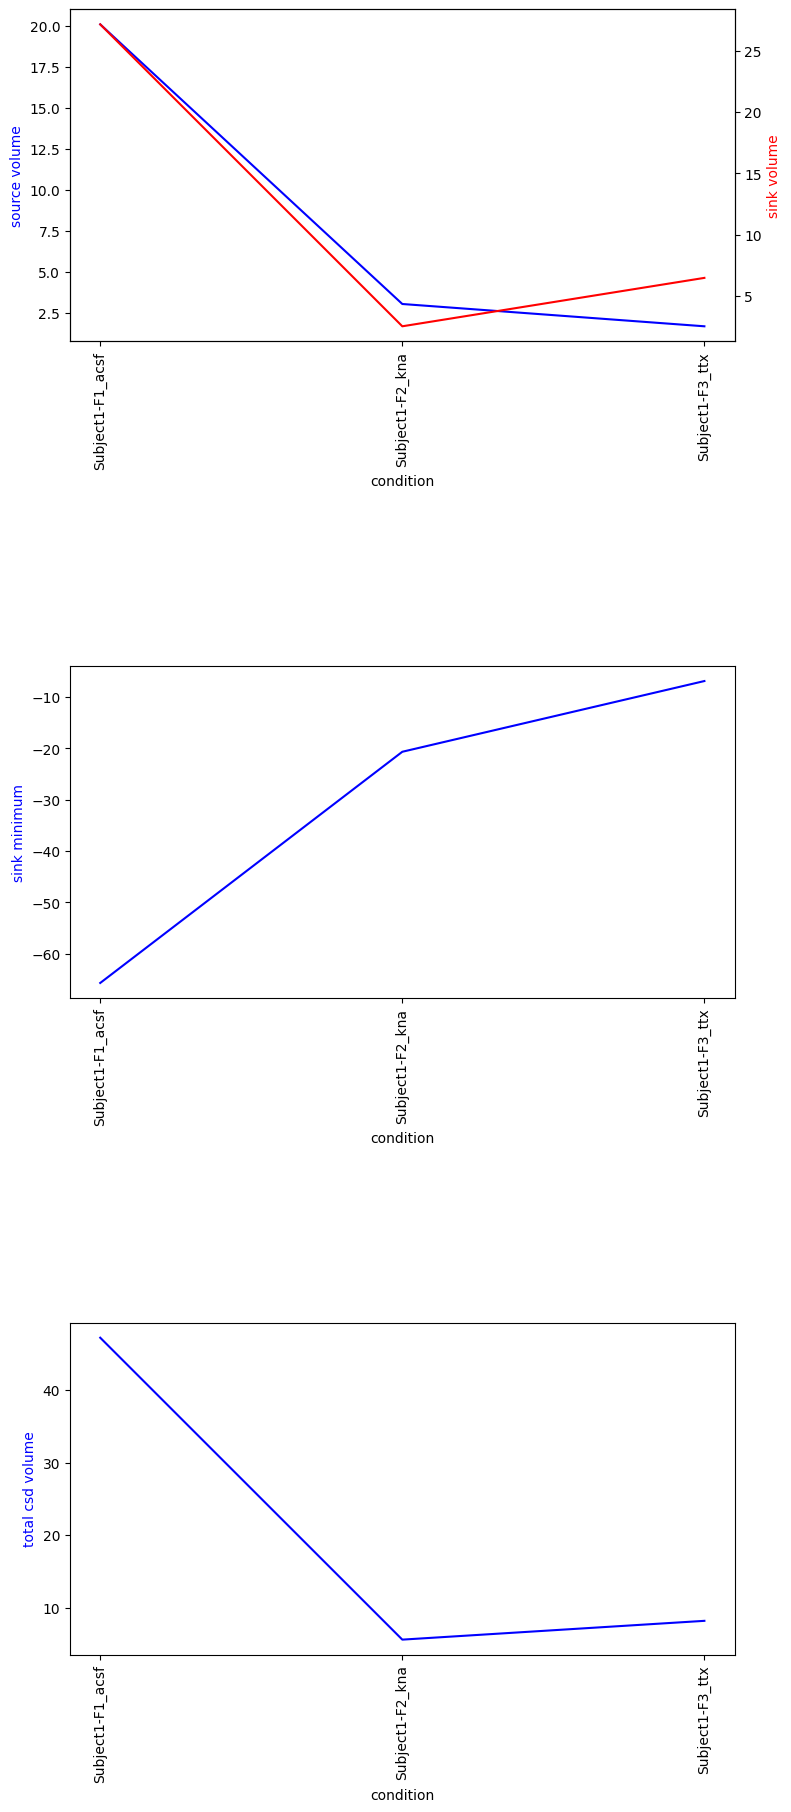

***************************DONE*****************************
***************************SAVED*****************************


In [682]:
csd_total_vol_table = []
csd_min_table = []
csd_cond_table = []
csd_source_vol_table = []
csd_sink_vol_table = []

csd_source_presynaptic_vol_table = []
csd_source_postsynaptic_vol_table = []

csd_sink_presynaptic_vol_table = []
csd_sink_postsynaptic_vol_table = []

csd_total_presynaptic_vol_table = []
csd_total_postsynaptic_vol_table = []

# plt.plot(postsynapticsource6a, label = "220406A")
# plt.plot(postsynapticsource6b, label = "220406B")
# plt.plot(postsynapticsource6d, label = "220406D")
# plt.plot(postsynapticsource8a, label = "220408A")
# plt.plot(postsynapticsource8c, label = "220408C")


#File folder location (needs forward slash at end)
#220406A
#experiment_folder_path = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/LFP/220406A/LEDtrig_stim_DM-220406-140426/"
#220406B
#experiment_folder_path = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/LFP/220406B/LEDtrig_stim_DM-220406-150441/"
#220406C
#experiment_folder_path = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/LFP/220406C/LEDtrig_stim_DM-220406-161429/"
#220406D
#experiment_folder_path = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/LFP/220406D/LEDtrig_stim_DM-220406-170824/"
#220408A
#experiment_folder_path ="C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/LFP/220408A/LEDtrig_stim_DM-220408-143144/"
#220408C
#experiment_folder_path = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/LFP/220408C/LEDtrig_stim_DM-220408-171323/"

#control data
experiment_folder_path = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/IGM_projects/Caged_STX/control_data/"

#experiment_folder_path = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/Desktop/test_folder/"



output_folder_path = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/temp/python_output/"


#slice_id = pathlib.Path(experiment_folder_path).resolve().parents[4 - 1]
#slice_id = os.path.split(os.path.dirname(experiment_folder_path))[-2]
slice_id = (experiment_folder_path.split("/"))[-3]
print(slice_id) 
#print(slice_id)

os.chdir(experiment_folder_path)

for folder_name in os.listdir('.'):
    
    if os.path.isdir(os.path.join(experiment_folder_path, folder_name)):
        
        print(folder_name)
        scaling_set = False
        complete_folder_path = f'{experiment_folder_path}{folder_name}/'    
        data, all_data = getData(complete_folder_path)
        new_time = plot_the_lfps(folder_name,all_data)
        #plot_the_lfps(data,folder_name)        
        csd_dict = avg_sweep(data,folder_name,scaling_set,new_time)
        two_dimen_csd(data,folder_name)
        quantify_csd(csd_dict,folder_name)
        
fig, (ax1,ax3,ax4) = plt.subplots(3, 1, figsize=(8, 10))        

# Plotting the source/sink sink volume
ax1.plot(csd_cond_table, csd_source_vol_table, color="blue")
ax1.set_xlabel("condition")
ax1.set_ylabel("source volume", color="blue")
ax2 = ax1.twinx()
ax2.plot(csd_cond_table,csd_sink_vol_table, color="red")
ax2.set_ylabel("sink volume", color="red")

#plot minimum sink
ax3.plot(csd_cond_table, csd_min_table, color="blue")
ax3.set_xlabel("condition")
ax3.set_ylabel("sink minimum", color="blue")

#plot total volume sink
ax4.plot(csd_cond_table, csd_total_vol_table, color="blue")
ax4.set_xlabel("condition")
ax4.set_ylabel("total csd volume", color="blue")

#plt.xticks(rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=90)

# Displaying the plot
plt.tight_layout()
save_fig_name = f'{output_folder_path}{slice_id}_csd_plot.png'
fig.set_size_inches(8, 20)
plt.savefig(save_fig_name,dpi=600)
plt.show()


# print(csd_source_presynaptic_vol_table)
# print(csd_source_postsynaptic_vol_table)

# print(csd_sink_presynaptic_vol_table)
# print(csd_sink_postsynaptic_vol_table)

# print(csd_total_presynaptic_vol_table)
# print(csd_total_postsynaptic_vol_table)

condition = folder_name

print("***************************DONE*****************************")
#save tables
csd_total_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_total_vol_table":csd_total_vol_table})
csd_total_vol_save_name = f'{output_folder_path}{slice_id}_csd_total_vol_table_df.txt'
csd_total_vol_table_df.to_csv(csd_total_vol_save_name, sep="\t", index=False)

csd_min_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_min_table":csd_min_table})
csd_min_table_save_name = f'{output_folder_path}{slice_id}_csd_min_table_df.txt'
csd_min_table_df.to_csv(csd_min_table_save_name, sep="\t", index=False)

csd_source_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_source_vol_table":csd_source_vol_table})
csd_source_vol_save_name = f'{output_folder_path}{slice_id}_csd_source_vol_table.txt'
csd_source_vol_table_df.to_csv(csd_source_vol_save_name, sep="\t", index=False)

csd_sink_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_sink_vol_table":csd_sink_vol_table})
csd_sink_vol_save_name = f'{output_folder_path}{slice_id}_csd_sink_vol_table.txt'
csd_sink_vol_table_df.to_csv(csd_sink_vol_save_name, sep="\t", index=False)

csd_source_presynaptic_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_source_presynaptic_vol_table":csd_source_presynaptic_vol_table})
csd_source_presynaptic_vol_save_name = f'{output_folder_path}{slice_id}_csd_source_presynaptic_vol_table_df.txt'
csd_source_presynaptic_vol_table_df.to_csv(csd_source_presynaptic_vol_save_name, sep="\t", index=False)

csd_source_postsynaptic_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_source_postsynaptic_vol_table":csd_source_postsynaptic_vol_table})
csd_source_postsynaptic_vol_save_name = f'{output_folder_path}{slice_id}_csd_source_postsynaptic_vol_table_df.txt'
csd_source_postsynaptic_vol_table_df.to_csv(csd_source_postsynaptic_vol_save_name, sep="\t", index=False)

csd_sink_presynaptic_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_sink_presynaptic_vol_table":csd_sink_presynaptic_vol_table})
csd_sink_presynaptic_vol_save_name = f'{output_folder_path}{slice_id}_csd_sink_presynaptic_vol_table_df.txt'
csd_sink_presynaptic_vol_table_df.to_csv(csd_sink_presynaptic_vol_save_name, sep="\t", index=False)

csd_sink_postsynaptic_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_sink_postsynaptic_vol_table":csd_sink_postsynaptic_vol_table})
csd_sink_postsynaptic_vol_save_name = f'{output_folder_path}{slice_id}_csd_sink_postsynaptic_vol_table_df.txt'
csd_sink_postsynaptic_vol_table_df.to_csv(csd_sink_postsynaptic_vol_save_name, sep="\t", index=False)

csd_total_presynaptic_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_total_presynaptic_vol_table":csd_total_presynaptic_vol_table})
csd_total_presynaptic_vol_save_name = f'{output_folder_path}{slice_id}_csd_total_presynaptic_vol_table_df.txt'
csd_total_presynaptic_vol_table_df.to_csv(csd_total_presynaptic_vol_save_name, sep="\t", index=False)

csd_total_postsynaptic_vol_table_df = pd.DataFrame({"csd_cond_table":csd_cond_table, "csd_total_postsynaptic_vol_table":csd_total_postsynaptic_vol_table})
csd_total_postsynaptic_vol_save_name = f'{output_folder_path}{slice_id}_csd_total_postsynaptic_vol_table_df.txt'
csd_total_postsynaptic_vol_table_df.to_csv(csd_total_postsynaptic_vol_save_name, sep="\t", index=False)


print("***************************SAVED*****************************")




